# ACN-Dataset on workplace charging

This dataset is available from here: https://ev.caltech.edu/dataset

In [3]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import holidays

import warnings
warnings.filterwarnings(action="ignore")

import json

In [4]:
DATA_PATH = "/Volumes/karsten.schroer@uni-koeln.de/Uni/Research/04_CASE_Clustered_EV_Charging/"
OUT_PATH = ""
facilities = ["Caltech","JPL","office1"]

The data contains three core facilities:
- __Caltech__: A research university located in Pasadena, CA. We currently collect data from 54 EVSEs in one campus garage. The site is open to the public but most usage is from faculty, staff and students.
- __JPL__: A national research lab located in La Canada, CA. This site currently has 50 EVSEs and is only open to employees. It is indicative of a normal workplace schedule.
- __office1__: An office building located in the Silicon Valley area. It currently has 8 EVSEs and is used only by employees.

# Access via API

This is the better way as it respects the time zone.

In [13]:
import requests as req
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import pytz

def http_date(dt):
    """ Convert datetime object into http date according to RFC 1123.
    :param datetime dt: datetime object to convert
    :return: dt as a string according to RFC 1123 format
    :rtype: str
    """
    return dt.astimezone(pytz.utc).strftime("%a, %d %b %Y %H:%M:%S GMT")

def add_user_input_cols (df):
    
    "Extracts user inputs and adds as columns"
    
    user_input_keys = ['WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable', 
                       'modifiedAt', 'paymentRequired', 'requestedDeparture', 'userID']
    
    for key in user_input_keys: #userInputs
        
        df["userInputs_"+key] = df["userInputs"].apply(lambda x: x[0][key] if type(x)==list else np.NaN)
        
    df.drop("userInputs",axis=1,inplace=True)
    
    return df

In [8]:
# Timezone of the ACN we are using.
timezone = pytz.timezone('America/Los_Angeles')

# Start and End times are used when collecting data.
start = timezone.localize(datetime(2019, 1, 1))
end = timezone.localize(datetime(2020, 1, 1))

# Identifier of the site where data will be gathered.
site = 'caltech'

In [9]:
api_token="69Na6QtGwXyxCO9inT_jZlVnK__pSN7Xxnw2aIg8Zls"
url = "https://ev.caltech.edu/api/v1/"

In [10]:
cond = []
cond.append('connectionTime >= "{0}"'.format(http_date(start)))
cond.append('connectionTime <= "{0}"'.format(http_date(end)))

#if min_energy is not None:
#    cond.append("kWhDelivered > {0}".format(min_energy))

condition = " and ".join(cond)
print(condition)

connectionTime >= "Tue, 01 Jan 2019 08:00:00 GMT" and connectionTime <= "Wed, 01 Jan 2020 08:00:00 GMT"


In [14]:
def get_sessions(api_token,url,site, cond=None, project=None, sort="connectionTime", timeseries=False):
        
        """ Returns sessions from the acndata dataset.
        Args:
            site (str): ACN ID from which data should be gathered.
            cond (str): String of conditions. See API reference for the where parameter.
        Yields:
            Dict: Session as a dictionary.
        Raises:
            ValueError: Raised if the site name is not valid.
        """
        
        if site not in {"caltech", "jpl", "office001"}:
            raise ValueError(
                "Invalid site name. Must be either 'caltech', 'jpl', or 'office001'.")

        limit = 1000000
        endpoint = "sessions/" + site
        if timeseries:
            endpoint += "/ts/"
            limit = 1000000
        args = []
        if cond is not None:
            args.append("where={0}".format(cond))
        if project is not None:
            args.append("project={0}".format(project))
        if sort is not None:
            args.append("sort={0}".format(sort))
        args.append("max_results={0}".format(limit))
        query_string = "?" + "&".join(args) if len(args) > 0 else ""
        
        print(query_string)
        
        call = req.get(url + endpoint + query_string, auth=(api_token, ""))
        call_json = call.json()
        
        data = pd.DataFrame()
        
        # flick through all pages in output
        while True:
            #for s in call_json["_items"]:
            #    parse_dates(s)
            if "next" in call_json["_links"]:
                call = req.get(url + call_json["_links"]["next"]["href"], auth=(api_token, ""))
                #print(url + call_json["_links"]["next"]["href"])
                call_json = call.json()
                call_df = pd.DataFrame(call_json["_items"])
                
                data = data.append(call_df)
                
            else:
                break
        
        data["siteName"] = site
        data = add_user_input_cols(data)

        # some formatting
        local_tz=pytz.timezone('America/Los_Angeles')
        
        for t_col in ['connectionTime', 'disconnectTime','doneChargingTime','userInputs_modifiedAt','userInputs_requestedDeparture']:
            data[t_col]= pd.to_datetime(data[t_col])
            data[t_col]= data[t_col].apply(lambda x: x.tz_convert(local_tz))
            
            # get naive non-tz aware local time 
            data[t_col]= data[t_col].apply(lambda x: x.replace(tzinfo=None)) # remove tz_info to only keep local time

        return data

In [15]:
final = pd.DataFrame()
for site in ["caltech", "jpl", "office001"]: #"caltech", "jpl", "office001"
    out = get_sessions(api_token,url,site, cond=condition, project=None, sort=None, timeseries=False)
    
    final=final.append(out)

?where=connectionTime >= "Tue, 01 Jan 2019 08:00:00 GMT" and connectionTime <= "Wed, 01 Jan 2020 08:00:00 GMT"&max_results=1000000
?where=connectionTime >= "Tue, 01 Jan 2019 08:00:00 GMT" and connectionTime <= "Wed, 01 Jan 2020 08:00:00 GMT"&max_results=1000000
?where=connectionTime >= "Tue, 01 Jan 2019 08:00:00 GMT" and connectionTime <= "Wed, 01 Jan 2020 08:00:00 GMT"&max_results=1000000


### Cleaning and Feature Computation

In [16]:
# extrapolate enty and exit time (allow for 3 min to connect)
final["EntryDateTime"] = final["connectionTime"].apply(lambda x: pd.to_datetime(x)-pd.Timedelta(minutes=3))
final["ExitDateTime"] = final["disconnectTime"].apply(lambda x: pd.to_datetime(x)+pd.Timedelta(minutes=3))

In [19]:
def weekday_flag (x):
    if x < 4:
        return 1
    else:
        return 0
    
def minutes(td):
    
    """Returns timedelta in minutes (Int)"""
    
    return td.days*24*60 + (td.seconds // 3600)*60 + (td.seconds//60)%60
    
def minutes_from_midnight (datetime_obj):
    mfm = datetime_obj.hour * 60 + datetime_obj.minute
    
    return mfm

In [25]:
# Create required features

#get temporal features
final["EntryDateTime"] = pd.to_datetime(final["EntryDateTime"])
final["ExitDateTime"] = pd.to_datetime(final["ExitDateTime"])

final['EntryMFM'] = final['EntryDateTime'].apply (lambda x: minutes_from_midnight(x) )
final['ExitMFM'] = final['ExitDateTime'].apply (lambda x: minutes_from_midnight(x) )

final["EntryDate"] = final["EntryDateTime"].apply(lambda x: x.date())
final["ExitDate"] = final["ExitDateTime"].apply(lambda x: x.date())
final["EntryHour"] = final["EntryDateTime"].apply(lambda x: x.hour)
final["ExitHour"] = final["ExitDateTime"].apply(lambda x: x.hour)

# Entry day
final["EntryDayOfWeek"] = final["EntryDateTime"].apply(lambda x: x.weekday())    
final["EntryWeekday_yn"] = final["EntryDayOfWeek"].apply(lambda x: weekday_flag(x))

# Duration of stay
final["DurationStay"] = final["ExitDateTime"]-final["EntryDateTime"]
final["MinutesStay"] = final["DurationStay"].apply(lambda x: minutes(x))
final["HoursStay"] = final["MinutesStay"]/60


# time is circular; we can reperesent by sine and cosine tranformation (see: https://datascience.stackexchange.com/questions/8799/boundary-conditions-for-clustering)
final["EntryHour_sin"] = final["EntryHour"].apply(lambda t: np.sin(2*np.pi*(t/24)))
final["EntryHour_cos"] = final["EntryHour"].apply(lambda t: np.cos(2*np.pi*(t/24)))
final["EntryMin_sin"] = final["EntryMFM"].apply(lambda t: np.sin(2*np.pi*(t/(24*60))))
final["EntryMin_cos"] = final["EntryMFM"].apply(lambda t: np.cos(2*np.pi*(t/(24*60))))

final["ExitHour_sin"] = final["ExitHour"].apply(lambda t: np.sin(2*np.pi*(t/24)))
final["ExitHour_cos"] = final["ExitHour"].apply(lambda t: np.cos(2*np.pi*(t/24)))
final["ExitMin_sin"] = final["ExitMFM"].apply(lambda t: np.sin(2*np.pi*(t/(24*60))))
final["ExitMin_cos"] = final["ExitMFM"].apply(lambda t: np.cos(2*np.pi*(t/(24*60))))

### Save Data

In [26]:
final.to_csv(DATA_PATH+"ACN_Caltech_Charging_Data/acndata_sessions_COMBINED_API.csv")

## Some Analysis

Requested Mileage [miles]

<AxesSubplot:xlabel='userInputs_milesRequested'>

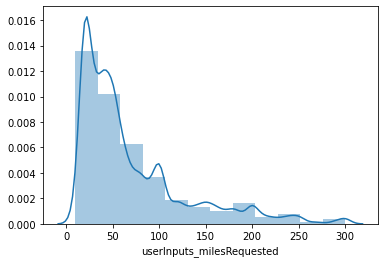

In [22]:
sns.distplot(final[final["userInputs_milesRequested"].isna()==False]["userInputs_milesRequested"],norm_hist=True,bins=12)

Requested Energy [kWh]

<AxesSubplot:xlabel='userInputs_kWhRequested'>

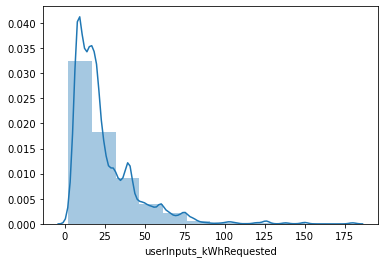

In [23]:
sns.distplot(final[final["userInputs_kWhRequested"].isna()==False]["userInputs_kWhRequested"],norm_hist=True,bins=12)

___

LEGACY CODE BELOW

## Data from web interface (has some issues regrading time zone conversion)

In [90]:
def add_user_input_cols (df):
    
    "Extracts user inputs and adds as columns"
    
    user_input_keys = ['WhPerMile', 'kWhRequested', 'milesRequested', 'minutesAvailable', 
                       'modifiedAt', 'paymentRequired', 'requestedDeparture', 'userID']
    
    for key in user_input_keys: #userInputs
        
        df["userInputs_"+key] = df["userInputs"].apply(lambda x: x[0][key] if type(x)==list else np.NaN)
        
    df.drop("userInputs",axis=1,inplace=True)
    
    return df

Data prep routine

In [5]:
final_data = pd.DataFrame()

for fac in facilities:

    with open(DATA_PATH+"ACN_Caltech_Charging_Data/acndata_sessions_{}.json".format(fac)) as f:
        data = json.load(f)
        data = pd.DataFrame(data["_items"])
        data["siteName"] = fac
        data = add_user_input_cols (data)

        # some formatting
        for t_col in ['connectionTime', 'disconnectTime','doneChargingTime','userInputs_modifiedAt','userInputs_requestedDeparture']:
            data[t_col]= pd.to_datetime(data[t_col])

        final_data = final_data.append(data)

Dates and Times seem off. We need to convert back to local time!

In [287]:
#final_data.to_csv(DATA_PATH+"ACN_Caltech_Charging_Data/acndata_sessions_COMBINED.csv")